Epoch 1/80 | loss 0.6263 acc 0.807 | val_loss 0.6307 val_acc 0.804
Epoch 8/80 | loss 0.2562 acc 0.919 | val_loss 0.2689 val_acc 0.916
Epoch 16/80 | loss 0.2087 acc 0.932 | val_loss 0.2387 val_acc 0.916
Epoch 24/80 | loss 0.1817 acc 0.944 | val_loss 0.2180 val_acc 0.928
Epoch 32/80 | loss 0.1629 acc 0.951 | val_loss 0.2079 val_acc 0.932
Epoch 40/80 | loss 0.1533 acc 0.959 | val_loss 0.1972 val_acc 0.940
Epoch 48/80 | loss 0.1371 acc 0.964 | val_loss 0.1961 val_acc 0.940
Epoch 56/80 | loss 0.1263 acc 0.964 | val_loss 0.1930 val_acc 0.938
Epoch 64/80 | loss 0.1210 acc 0.969 | val_loss 0.1886 val_acc 0.946
Epoch 72/80 | loss 0.1138 acc 0.969 | val_loss 0.1847 val_acc 0.948
Epoch 80/80 | loss 0.1014 acc 0.975 | val_loss 0.1887 val_acc 0.948

Train Loss:0.1014 Acc:0.975
Test  Loss:0.1887 Acc:0.948


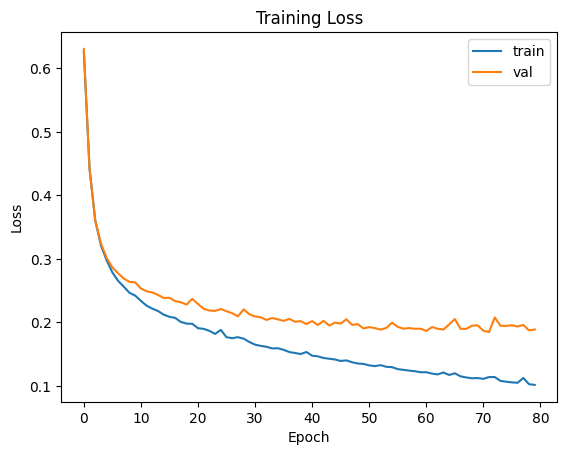

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# ---------- Utility functions ----------
def one_hot(y):
    """Convert integer labels to one-hot vectors (compatible with sklearn ≥1.2)."""
    try:
        enc = OneHotEncoder(sparse_output=False)   # new versions
    except TypeError:
        enc = OneHotEncoder(sparse=False)          # fallback for old versions
    return enc.fit_transform(y.reshape(-1, 1))

def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)  # for numerical stability
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def cross_entropy(probs, y_true):
    N = y_true.shape[0]
    probs = np.clip(probs, 1e-12, 1.0)
    return -np.sum(y_true * np.log(probs)) / N

# ---------- Neural Network Class ----------
class NeuralNet:
    def __init__(self, layers, lr=0.05, reg=1e-4, seed=42):
        """
        layers : list like [input_dim, h1, h2, ..., output_dim]
        lr     : learning rate
        reg    : L2 regularization strength
        """
        np.random.seed(seed)
        self.lr = lr
        self.reg = reg
        self.L = len(layers) - 1
        self.W, self.b = {}, {}
        for i in range(self.L):
            # He initialization for ReLU layers
            self.W[i] = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
            self.b[i] = np.zeros((1, layers[i+1]))

    def forward(self, X):
        A = X
        caches = {"A0": A}
        for l in range(self.L):
            Z = A @ self.W[l] + self.b[l]
            caches[f"Z{l+1}"] = Z
            if l == self.L - 1:
                A = softmax(Z)
            else:
                A = relu(Z)
            caches[f"A{l+1}"] = A
        return caches

    def backward(self, caches, X, Y):
        grads = {}
        N = X.shape[0]
        dZ = caches[f"A{self.L}"] - Y   # softmax + cross-entropy
        for l in reversed(range(self.L)):
            A_prev = caches[f"A{l}"]
            grads[f"dW{l}"] = (A_prev.T @ dZ) / N + self.reg * self.W[l]
            grads[f"db{l}"] = np.sum(dZ, axis=0, keepdims=True) / N
            if l > 0:
                dA_prev = dZ @ self.W[l].T
                dZ = dA_prev * relu_derivative(caches[f"Z{l}"])
        return grads

    def update(self, grads):
        for l in range(self.L):
            self.W[l] -= self.lr * grads[f"dW{l}"]
            self.b[l] -= self.lr * grads[f"db{l}"]

    def loss_acc(self, X, Y):
        caches = self.forward(X)
        probs = caches[f"A{self.L}"]
        loss = cross_entropy(probs, Y)
        for l in range(self.L):
            loss += 0.5 * self.reg * np.sum(self.W[l]**2)
        preds = np.argmax(probs, axis=1)
        acc = np.mean(preds == np.argmax(Y, axis=1))
        return loss, acc

    def fit(self, X, Y, X_val, Y_val, epochs=80, batch=64):
        n = X.shape[0]
        hist = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
        for e in range(1, epochs+1):
            idx = np.random.permutation(n)
            for i in range(0, n, batch):
                b = idx[i:i+batch]
                caches = self.forward(X[b])
                grads = self.backward(caches, X[b], Y[b])
                self.update(grads)
            tr_loss, tr_acc = self.loss_acc(X, Y)
            val_loss, val_acc = self.loss_acc(X_val, Y_val)
            hist["loss"].append(tr_loss)
            hist["val_loss"].append(val_loss)
            hist["acc"].append(tr_acc)
            hist["val_acc"].append(val_acc)
            if e % 8 == 0 or e == 1 or e == epochs:
                print(f"Epoch {e}/{epochs} | loss {tr_loss:.4f} acc {tr_acc:.3f} "
                      f"| val_loss {val_loss:.4f} val_acc {val_acc:.3f}")
        return hist

# ---------- Demo Training ----------
# synthetic 3-class dataset
X, y = make_classification(n_samples=2000, n_features=10,
                           n_informative=6, n_classes=3,
                           n_clusters_per_class=1, random_state=0)
# standardize features
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25,
                                      random_state=1, stratify=y)
Ytr, Yte = one_hot(ytr), one_hot(yte)

net = NeuralNet([10, 64, 32, 3], lr=0.05, reg=1e-4)
history = net.fit(Xtr, Ytr, Xte, Yte, epochs=80, batch=64)

# final evaluation
train_loss, train_acc = net.loss_acc(Xtr, Ytr)
test_loss, test_acc = net.loss_acc(Xte, Yte)
print(f"\nTrain Loss:{train_loss:.4f} Acc:{train_acc:.3f}")
print(f"Test  Loss:{test_loss:.4f} Acc:{test_acc:.3f}")

# plot training curve
plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()
